In [5]:
import tarfile
import torchvision.transforms as tt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import f1_score,confusion_matrix
import os
import torch
from PIL import Image
import wandb
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
from sklearn import preprocessing
import torch.nn as nn
import scipy.io
import pandas as pd
import numpy as np

In [6]:
wandb.login()
wandb.init(project="SML", entity="iiit-d")

wandb: Currently logged in as: tarang22081 (iiit-d). Use `wandb login --relogin` to force relogin


In [7]:
from pytorch_pretrained_vit import ViT

# Define the ViT model architecture
model = ViT('B_16', num_classes=1000, pretrained=True)

# Modify the last layer to output 397 classes
model.fc = nn.Linear(model.fc.in_features, 200)

Loaded pretrained weights.


In [8]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name[:3]: idx for idx, cls_name in enumerate(self.classes)}
        self.images = self._get_images()

    def _get_images(self):
        images = []
        # print(self.class_to_idx)
        for class_folder in self.classes:
            class_path = os.path.join(self.root_dir, class_folder)
            class_idx = self.class_to_idx[class_folder[:3]]
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                images.append((img_path, class_idx))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, class_idx = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, class_idx

# Example usage
root_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\train'
test_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\test'
train_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\new_train'
val_dir = 'C:\\Users\\taran\\Downloads\\SML\\CUB-200-2011-dataset-main\\CUB-200-2011-dataset-main\\new_val'
trans = tt.Compose([
    tt.ToTensor(),tt.Resize((224,224)),tt.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))   
])

trans_aug = tt.Compose([
   tt.ToTensor(), tt.Resize((224,224)),
   tt.RandomGrayscale(), tt.RandomHorizontalFlip(),
   tt.RandomRotation(degrees=20), tt.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])


In [9]:
# train_dataset = CustomDataset(root_dir, transform=trans)
train_ds = CustomDataset(train_dir, transform=trans_aug)
val_ds = CustomDataset(val_dir, transform=trans)
test_ds = CustomDataset(test_dir, transform=trans)

In [10]:
batch = 4

In [11]:
train_dl = DataLoader(train_ds,batch, shuffle=True)
val_dl = DataLoader(val_ds,batch, shuffle=True)
test_dl = DataLoader(test_ds,batch, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


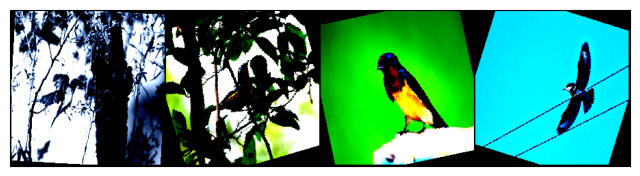

In [12]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))
    

def show_batch(dl, nmax=64):
    for images, label in dl:
        show_images(images, nmax)
        break
show_batch(train_dl,64)

In [13]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
train_dl = DeviceDataLoader(train_dl,'cuda')
val_dl = DeviceDataLoader(val_dl,'cuda')

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == (labels)).item() / len(preds))


class Model(nn.Module):
  def __init__(self ):
    super().__init__()
    self.network =model

  def forward(self, x):
    return self.network(x)
  
  def train_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred,label)
      return loss
  
  def valid_step(self,batch):
      img , label = batch
      pred = self(img)
      loss = F.cross_entropy(pred, label)  
      acc = accuracy(pred, label)
      return {'acc':acc , 'loss':loss.item()}

  def valid_metric_cals(self,output):
    loss = [i['loss'] for i in output]
    acc = [i['acc'] for i in output]
    valid_loss = np.mean(loss)
    valid_acc = np.mean(acc)
    return {'val_loss':valid_loss,'valid_acc':valid_acc}
  
  def epoch_end(self, epoch_no , result):
    wandb.log({ 'epoch' : epoch_no+1, 'training loss': result["train_loss"], 'validation loss': result["val_loss"], 'accuracy': result["valid_acc"]})
    print(f'epoch :{epoch_no+1}, training loss: {result["train_loss"]}, validation loss: {result["val_loss"]}, accuracy: {result["valid_acc"]}')

In [15]:
@torch.no_grad()
def evalu(model, val_dl):
  model.eval()
  temp = [ model.valid_step(j) for j in val_dl ]
  return model.valid_metric_cals(temp)

def fit(train_dl,val_dl,model,lr,optim,epochs,momentum):
  history = []
  optimizer =  optim(model.parameters(),lr=lr,momentum=0.9)
  count = 0
  for epoch in tqdm(range(epochs)):
    train_loss = []
    model.train()
    for batch in train_dl:
      optimizer.zero_grad()
      loss = model.train_step(batch)
      loss.backward()
      
      train_loss.append(loss.item())
      optimizer.step()
      # print(count)
      count+=1
    result = evalu(model,val_dl)
    result['train_loss'] = np.mean(train_loss)
    history.append(result)
    model.epoch_end(epoch,result)
  return history

    

In [16]:
model = Model()
model = to_device(model,'cuda')
lr = 0.001
momentum =.9
optimizer= torch.optim.SGD
epochs=30
wandb.config = {'lr':lr,'optimuzer':'SGD','epochs':epochs,'batch_size':batch}

In [17]:
# wandb.watch(model)
history=fit(train_dl,val_dl,model,lr,optimizer,epochs,momentum)

  3%|██▋                                                                             | 1/30 [12:27<6:01:26, 747.81s/it]

epoch :1, training loss: 4.958945323667296, validation loss: 4.323174815177918, accuracy: 0.5833333134651184


  7%|█████▎                                                                          | 2/30 [28:38<6:50:13, 879.05s/it]

epoch :2, training loss: 3.4672250359927346, validation loss: 2.151924601395925, accuracy: 0.684166669845581


 10%|████████                                                                        | 3/30 [44:48<6:54:17, 920.66s/it]

epoch :3, training loss: 1.7147630132467573, validation loss: 1.118339350769917, accuracy: 0.7391666769981384


 13%|██████████▍                                                                   | 4/30 [1:01:05<6:48:28, 942.62s/it]

epoch :4, training loss: 1.0859340026017723, validation loss: 0.9287525684386492, accuracy: 0.7358333468437195


 17%|█████████████                                                                 | 5/30 [1:17:34<6:39:50, 959.62s/it]

epoch :5, training loss: 0.8769578418171684, validation loss: 0.7911058272669713, accuracy: 0.7875000238418579


 20%|███████████████▌                                                              | 6/30 [1:34:07<6:28:19, 970.83s/it]

epoch :6, training loss: 0.7482554206595111, validation loss: 0.7918599275189141, accuracy: 0.7766666412353516


 23%|██████████████████▏                                                           | 7/30 [1:50:16<6:11:57, 970.33s/it]

epoch :7, training loss: 0.5916094958667237, validation loss: 0.677817791790391, accuracy: 0.8016666769981384


 27%|████████████████████▊                                                         | 8/30 [2:06:26<5:55:40, 970.03s/it]

epoch :8, training loss: 0.523441937411075, validation loss: 0.6315069477291156, accuracy: 0.8208333253860474


 30%|███████████████████████▍                                                      | 9/30 [2:22:33<5:39:13, 969.23s/it]

epoch :9, training loss: 0.4526326557849724, validation loss: 0.6697059314046055, accuracy: 0.8208333253860474


 33%|█████████████████████████▋                                                   | 10/30 [2:38:36<5:22:23, 967.19s/it]

epoch :10, training loss: 0.3934673032124493, validation loss: 0.6262805450924983, accuracy: 0.8166666626930237


 37%|████████████████████████████▏                                                | 11/30 [2:54:36<5:05:36, 965.06s/it]

epoch :11, training loss: 0.32918539711097883, validation loss: 0.639187185857445, accuracy: 0.815833330154419


 40%|██████████████████████████████▊                                              | 12/30 [3:10:22<4:47:44, 959.13s/it]

epoch :12, training loss: 0.28621040600615305, validation loss: 0.6560972065618261, accuracy: 0.8199999928474426


 43%|█████████████████████████████████▎                                           | 13/30 [3:25:30<4:27:22, 943.69s/it]

epoch :13, training loss: 0.2315008323841586, validation loss: 0.6764567193606248, accuracy: 0.8083333373069763


 47%|███████████████████████████████████▉                                         | 14/30 [3:37:12<3:52:12, 870.79s/it]

epoch :14, training loss: 0.280662149665885, validation loss: 0.6700603613692026, accuracy: 0.815833330154419


 50%|██████████████████████████████████████▌                                      | 15/30 [3:44:19<3:04:13, 736.89s/it]

epoch :15, training loss: 0.21192110535530242, validation loss: 0.7030039109677697, accuracy: 0.8174999952316284


 53%|█████████████████████████████████████████                                    | 16/30 [3:51:40<2:31:10, 647.89s/it]

epoch :16, training loss: 0.1877212170422158, validation loss: 0.6829327356815338, accuracy: 0.815833330154419


 57%|███████████████████████████████████████████▋                                 | 17/30 [3:59:07<2:07:16, 587.41s/it]

epoch :17, training loss: 0.20401801110487633, validation loss: 0.6916305062128231, accuracy: 0.8208333253860474


 60%|██████████████████████████████████████████████▏                              | 18/30 [4:06:35<1:49:09, 545.76s/it]

epoch :18, training loss: 0.14738040374381448, validation loss: 0.7022298014955595, accuracy: 0.8125


 63%|████████████████████████████████████████████████▊                            | 19/30 [4:14:05<1:34:44, 516.74s/it]

epoch :19, training loss: 0.14982632593629652, validation loss: 0.8260820520063862, accuracy: 0.7858333587646484


 67%|███████████████████████████████████████████████████▎                         | 20/30 [4:21:34<1:22:44, 496.47s/it]

epoch :20, training loss: 0.1449049265778121, validation loss: 0.7053178823793618, accuracy: 0.8241666555404663


 70%|█████████████████████████████████████████████████████▉                       | 21/30 [4:29:04<1:12:22, 482.47s/it]

epoch :21, training loss: 0.13165212267026416, validation loss: 0.7016048243090821, accuracy: 0.8308333158493042


 73%|████████████████████████████████████████████████████████▍                    | 22/30 [4:36:36<1:03:06, 473.28s/it]

epoch :22, training loss: 0.13018070896963174, validation loss: 0.718346145292744, accuracy: 0.824999988079071


 77%|████████████████████████████████████████████████████████████▌                  | 23/30 [4:44:06<54:25, 466.53s/it]

epoch :23, training loss: 0.12628687259026905, validation loss: 0.7998536385068049, accuracy: 0.8100000023841858


 80%|███████████████████████████████████████████████████████████████▏               | 24/30 [4:51:36<46:08, 461.42s/it]

epoch :24, training loss: 0.10708970392745817, validation loss: 0.7280928381718695, accuracy: 0.8191666603088379


 83%|█████████████████████████████████████████████████████████████████▊             | 25/30 [4:59:05<38:09, 457.88s/it]

epoch :25, training loss: 0.13151235375502882, validation loss: 0.7863165716896765, accuracy: 0.800000011920929


 87%|████████████████████████████████████████████████████████████████████▍          | 26/30 [5:06:33<30:19, 454.91s/it]

epoch :26, training loss: 0.12011512358703211, validation loss: 0.7492045695305569, accuracy: 0.8108333349227905


 90%|███████████████████████████████████████████████████████████████████████        | 27/30 [5:14:03<22:39, 453.30s/it]

epoch :27, training loss: 0.10426023323137432, validation loss: 0.729090243234532, accuracy: 0.8141666650772095


 93%|█████████████████████████████████████████████████████████████████████████▋     | 28/30 [5:21:33<15:04, 452.19s/it]

epoch :28, training loss: 0.09547159624219195, validation loss: 0.7181126836584493, accuracy: 0.8241666555404663


 97%|████████████████████████████████████████████████████████████████████████████▎  | 29/30 [5:29:01<07:31, 451.20s/it]

epoch :29, training loss: 0.10905257496556378, validation loss: 0.7793840765013981, accuracy: 0.809166669845581


100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [5:36:31<00:00, 673.04s/it]

epoch :30, training loss: 0.10533229004353047, validation loss: 0.8291873789175103, accuracy: 0.7891666889190674


In [18]:
torch.save(model.state_dict(),"VisionTransformer.pth")

In [19]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score

test_dl = DeviceDataLoader(test_dl,'cuda')
@torch.no_grad()
def test_accuracy_f1(test_dl):
  model.eval()
  acc=0
  f1=0
  list_label = []
  list_pred = []
  

  for num,(img,label) in enumerate(test_dl):
    outputs = model(img)
    batchs_report = []
    _, pred = torch.max(outputs, dim=1)
    predx,labelx = (pred.cpu().clone().tolist(),label.cpu().clone().tolist())
    
    list_label+=labelx
    list_pred+=predx
  f1 =f1_score(list_label,list_pred,average='macro')
  precision =precision_score(list_label,list_pred,average='macro')
  recall =recall_score(list_label,list_pred,average='macro')

  acc =accuracy_score(list_label,list_pred)
  wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                       y_true=list_label, preds=list_pred,
                     )})
  wandb.log({'f1_score':f1,'accuracy_score':acc,'precision Score':precision,'recall Score':recall})
  return f'f1 Score: {f1}', f'Accuracy: {acc}',f'precision Score: {precision}',f'recall Score: {recall}'
score_rate = test_accuracy_f1(test_dl)
print(score_rate)



('f1 Score: 0.8034486107944212', 'Accuracy: 0.8061788056610286', 'precision Score: 0.8175920791409133', 'recall Score: 0.8068566241967963')


In [20]:
wandb.finish()

accuracy,▁▄▅▅▇▆▇█████▇████▇▇███▇█▇▇██▇▇
accuracy_score,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
f1_score,▁
precision Score,▁
recall Score,▁
training loss,█▆▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.78917
accuracy_score,0.80618
epoch,30
